In [183]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy
import itertools as it
import mercury as mr # for widgets
import pandas as pd

from matplotlib.lines import Line2D

seed = 123
rng = np.random.default_rng(seed)
np.random.seed(seed)

# az.style.use("arviz-darkgrid")
# %config InlineBackend.figure_format = "retina"

In [184]:
class Environment:
    def __init__(self, lb, ub, noption, tmax):
        # p of each option
        self.p = [
            [.75, .25],
            [.25, .75],
            [.75, .75],
            [.25, .25]
        ]
        self.ncontext = len(self.p)
        self.con = np.sort(np.repeat(range(len(self.p)), tmax/len(self.p)))
        self.noption = noption
        self.tmax = tmax

    def play(self, s, a):
        # for convenience we only use -1 and + 1 rewards
        return np.random.choice(
            (0, 1),
            p=[1 - self.p[s][a], self.p[s][a]]
        )


class Agent:

    """
    Agent abstract model
    """

    def __init__(self, *args, **kwargs):
        self.name = kwargs['name']
        self.noption = kwargs['noption']
        self.tmax = kwargs['tmax']

        self.beta = kwargs['beta']
        self.value = np.zeros((kwargs['ncontext'], self.noption))

        # Data to store
        self.reward = np.empty(kwargs['tmax'], dtype=int)
        self.action = np.empty(kwargs['tmax'], dtype=int)
        self.state = np.empty(kwargs['tmax'], dtype=int)
        self.regret = np.empty(kwargs['tmax'], dtype=int)

    def make_choice(self, s):
        """
        returns a choice based on softmax output
        :return:
        """
        if sum(np.isnan(self.softmax(s))) > 0:
            print(self.softmax(s))
            
        return np.random.choice(range(self.noption), p=self.softmax(s))

    def softmax(self, s):
        """
        use prior means/ qvalues in order to compute options' probabilities
        :return:
        """
        f = np.exp(self.beta * (self.value[s,:] - np.max(self.value[s,:])))  # shift values
        return f / f.sum(axis=0)

        # return np.exp(
            # self.beta * self.value[s, :] + 1e-10
        # ) / sum(np.exp(self.beta * self.value[s, :] + 1e-10))

    def learn(self, *args, **kwargs):
        raise NotImplementedError

    def remember(self, s, a, r, t):
        self.reward[t] = r
        self.state[t] = s
        self.action[t] = a
        self.regret[t + 1] = self.regret[t] + (1 - r)


class QLearning(Agent):
    def __init__(self, alpha, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.q = np.ones((kwargs['ncontext'], self.noption)) * q0
        self.value = self.q

    def learn(self, s, a, r):
        """
        :param s: state
        :param a: action
        :param r: reward
        :return:
        """
        self.q[s, a] += self.alpha * (r - self.q[s, a])


class AsymmetricQLearning(Agent):
    def __init__(self, alpha1, alpha2, q0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.q = np.ones((kwargs['ncontext'], self.noption)) * q0
        self.value = self.q

    def learn(self, s, a, r):
        """
        :param s: state
        :param a: action
        :param r: reward
        :return:
        """
        pe = r - self.q[s, a]
        self.q[s, a] += self.alpha1 * pe * \
            (pe > 0) + self.alpha2 * pe * (pe < 0)



In [185]:
# Environment
noption = 2
ncontext = 4
tmax = 96


In [186]:
mr.App(title="RL simulations and fitting")


# dist of agents
mr.Markdown("# Simulation")
mr.Markdown("## Imagine two populations of agents of size 25. One with a single learning rate, the other with two learning rates, that may result in several biases. You can tweak the alpha parameters to see how the distributions of the two populations differ.")
# nagents1 = mr.Slider(label="N subjects with a single learning rate", min=0, max=10, step=1, value=5).value
# nagents2 = mr.Slider(label="N subjects with two learning rates", min=0, max=10, step=1, value=5).value
nagents1 = 25
nagents2 = 25

alpha = mr.Slider(label="alpha (RW model)", min=0, max=10, step=1, value=5)

alpha1 = mr.Slider(label="alpha+ (RW± model)", min=0, max=10, step=1, value=5)
alpha2 = mr.Slider(label="alpha- (RW± model)", min=0, max=10, step=1, value=5)



mercury.App

# Simulation

## Imagine two populations of agents of size 25. One with a single learning rate, the other with two learning rates, that may result in several biases. You can tweak the alpha parameters to see how the distributions of the two populations differ.

mercury.Slider

mercury.Slider

mercury.Slider

In [187]:
np.random.seed(123)
# dist of learning rates
alpha = np.random.normal(alpha.value/10, .008, size=nagents1)
alpha1 = np.random.normal(alpha1.value/10, .008, size=nagents2)
alpha2 = np.random.normal(alpha2.value/10, .008, size=nagents2)

alpha[alpha < 0] = 0
alpha[alpha > 1] = 1
alpha1[alpha1 < 0] = 0
alpha2[alpha2 < 0] = 0
alpha1[alpha1 > 1] = 1
alpha2[alpha2 > 1] = 1
# alpha[:] = 0

# Agents
agents = [
    QLearning(
        name="RW",
        alpha=alpha[_],
        q0=0.5,
        beta=3,
        noption=noption,
        tmax=tmax,
        ncontext=ncontext,
    ) for _ in range(nagents1)] + [
    AsymmetricQLearning(
        name="RW±",
        alpha1=alpha1[_],
        alpha2=alpha2[_],
        q0=0.5,
        beta=3,
        noption=noption,
        tmax=tmax,
        ncontext=ncontext,
    ) for _ in range(nagents2)
]

data = []
# Run simulations
for i, agent in enumerate(agents):
    env = Environment(lb=0.1, ub=0.9, noption=noption, tmax=tmax)
    for t in range(env.tmax):
        s = env.con[t]
        a = agent.make_choice(s)
        r = env.play(s, a)
        if t < env.tmax - 1:
            agent.learn(s, a, r)
            data.append({
                "model": agent.name,
                "id": i,
                "t": t,
                "s": s,
                "a": a,
                "r": r,
                "correct": a == 0 if s == 0 else a == 0 if s==1 else True,
                "alpha": getattr(agent, "alpha", None),
                "alpha1": getattr(agent, "alpha1", None),
                "alpha2": getattr(agent, "alpha2", None),
            })

data = pd.DataFrame(data)



Text(0, 0.5, 'density')

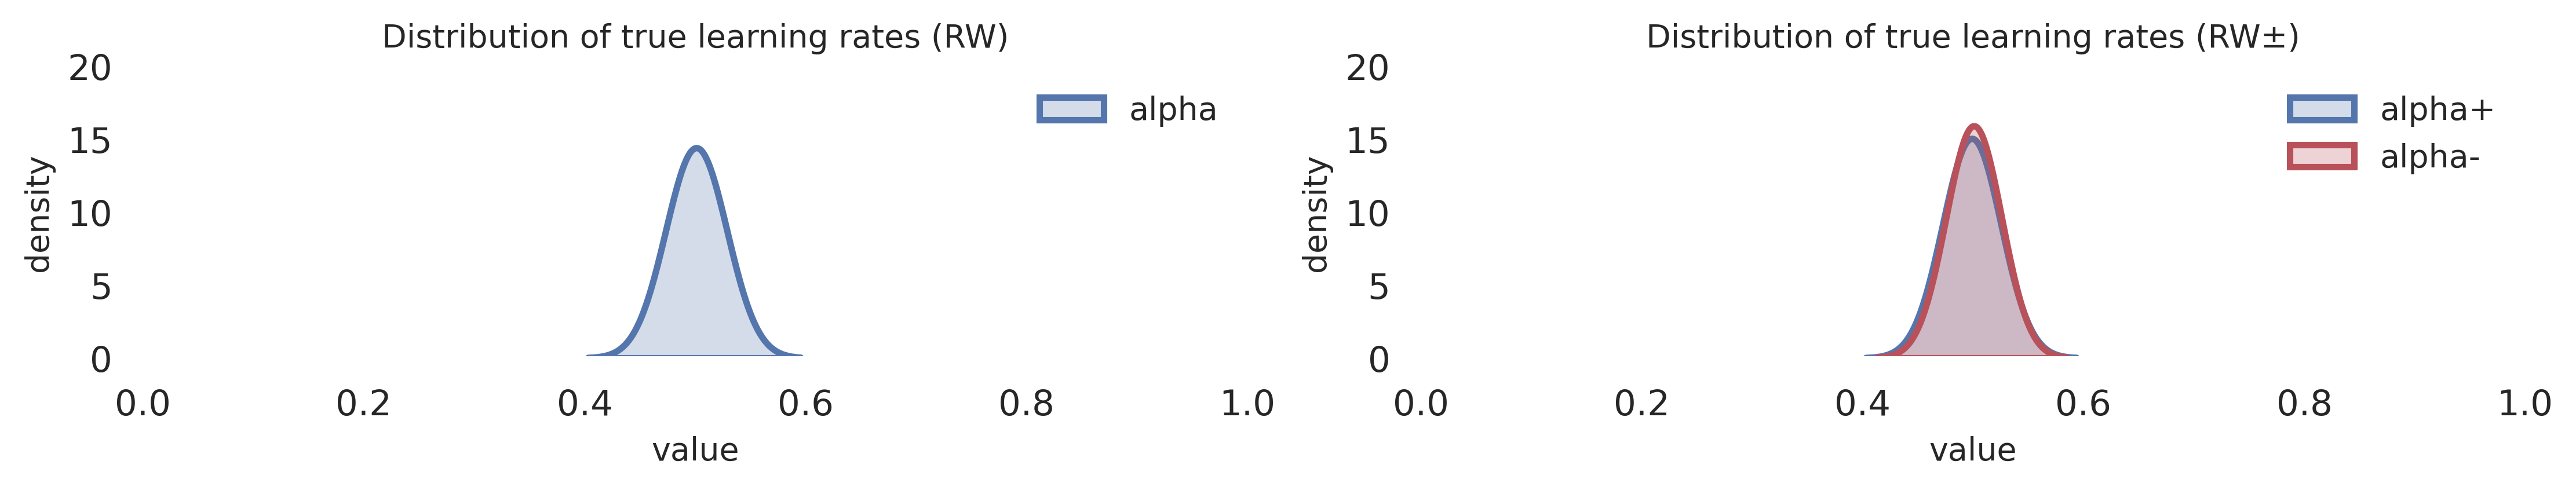

In [188]:
import seaborn as sns
from matplotlib import colors as mcolors

c = ["#5476AC", "#B9515A"]
c = list(map(lambda x: mcolors.to_rgba(x), c))
x = pd.DataFrame({'Alpha+': alpha1, 'Alpha-': alpha2})
x1 = pd.DataFrame({'Alpha': alpha})

sns.set(rc={'figure.figsize':(11,2), 'figure.dpi': 200, 'axes.facecolor': 'white', 'figure.facecolor': 'white'})

plt.subplot(1, 2, 1)
sns.kdeplot(x1["Alpha"], bw_adjust=5, fill=True, color=c[0], label='alpha', lw=2, clip=(0, 1)) 
# sns.histplot(x["option A"], color=c[1], label='option A', lw=4, stat='probability', bins=20)
# sns.histplot(x["option B"], color=c[0], label='option B', lw=4, stat='probability', bins=20)
# g2.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g1.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.legend(loc='upper right', frameon=False, fontsize=10)
sns.despine(left=True)

plt.title('Distribution of true learning rates (RW)', fontdict={'size': 10})
plt.ylim([0, 20])
plt.xlim([0, 1])
plt.xlabel('value', fontdict={'size': 10})
plt.ylabel('density', fontdict={'size': 10})

plt.subplot(1, 2, 2)
sns.kdeplot(x["Alpha+"], bw_adjust=5, fill=True, color=c[0], label='alpha+', lw=2, clip=(0, 1)) 
sns.kdeplot(x["Alpha-"], bw_adjust=5, fill=True, color=c[1], label='alpha-', lw=2, clip=(0, 1))
# sns.histplot(x["option A"], color=c[1], label='option A', lw=4, stat='probability', bins=20)
# sns.histplot(x["option B"], color=c[0], label='option B', lw=4, stat='probability', bins=20)
# g2.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
# g1.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
plt.legend(loc='upper right', frameon=False, fontsize=10)
sns.despine(left=True)

plt.title('Distribution of true learning rates (RW±)', fontdict={'size': 10})
plt.ylim([0, 20])
plt.xlim([0, 1])
plt.xlabel('value', fontdict={'size': 10})
plt.ylabel('density', fontdict={'size': 10})

In [189]:
def fit(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    model, noption, nstate, a, s, r = args
    
    # Initialize values
    Q = np.zeros((nstate, noption))
    logp_actions = np.zeros(len(a))
    beta = x[0]
    if model == "RW":
        alpha = x[1]
    elif model == "RW±":
        alpha1 = x[1]
        alpha2 = x[2]

    for t, (a, s, r) in enumerate(zip(a, s, r)):
        # Apply the softmax transformation
        Q_ = Q[s,:] * beta
        logp_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        logp_actions[t] = logp_action[a]

        # Update the Q values for the next trial
        if model == "RW":
            Q[s, a] += alpha * (r - Q[s, a])
        elif model == "RW±":
            pe = (r - Q[s, a])
            Q[s, a] += alpha1 *  pe * (pe > 0) + alpha2 *  pe * (pe < 0)

    # Return the negative log likelihood of all observed actions
    return -np.sum(logp_actions[1:])

In [190]:
mr.Markdown("## When you click the run button, the agents will play the game (same task as in the slides) and learn. You can see below, the probability of choosing the rightmost option over time given the model.")
button1 = mr.Button(label="Run", style="primary")
 
if button1.clicked:
    sns.lineplot(data, x="t", y="a", hue="model", style="model", markers=True, errorbar='se')
    plt.ylabel('P(choose action 1)')
    plt.show()

    mr.Markdown("## Now we will try to fit our models to the newly generated data, and retrieve our true parameters. To do that, click the fit button.")

    

## When you click the run button, the agents will play the game (same task as in the slides) and learn. You can see below, the probability of choosing the rightmost option over time given the model.

mercury.Button

In [191]:
button2 = mr.Button(label="Fit", style="primary")

# after button clicked this will be true
# but it will be true only once!
fit_data = []
if button2.clicked:
    mr.Markdown("# Fitting")
    x0 = np.array([3, 0.5])
    x1 = np.array([3, 0.5, .5])
    for i in data.id.unique():
        df = data[data.id == i]
        result1 = scipy.optimize.minimize(fit, x0, args=(
            'RW', noption, ncontext, df.a, df.s, df.r), method="L-BFGS-B", bounds=((0, 100), (0, 1)))
        alpha = result1.x[1]
        beta1 = result1.x[0]
        ll1 = result1.fun
        result2 = scipy.optimize.minimize(fit, x1, args=(
            'RW±', noption, ncontext, df.a, df.s, df.r), method="L-BFGS-B", bounds=((0, 100), (0, 1), (0, 1)))
        alpha1 = result2.x[1]
        alpha2 = result2.x[2]
        beta2 = result2.x[0]
        ll2 = result2.fun
        fit_data.append({
            "id": i,
            "alpha": alpha,
            "alpha1": alpha1,
            "alpha2": alpha2,
            "beta1": beta1,
            "beta2": beta2,
            "ll1": ll1,
            "ll2": ll2,
            "true": data.model[data.id == i].values[0]
        })

    fit_data = pd.DataFrame(fit_data)
    sns.set({'figure.figsize': (20, 4)})
    sns.set_style('white')
    # plt.subplot(2, 1, 1)

    # fit_data['BIC_RW'] = -2 * fit_data.ll1 + 2 * np.log(tmax)
    # fit_data['BIC_RW±'] = -2 * fit_data.ll2 + 3 * np.log(tmax)
    # fit_data['ΔBIC'] = fit_data['BIC_RW'] - fit_data['BIC_RW±']
    
    # sns.barplot(x='id', y='ΔBIC', data=fit_data, alpha=.5)
    # plt.show()

    plt.subplot(1, 9, 1)

    df1 = fit_data[fit_data.true == 'RW']
    sns.barplot(df1.alpha, alpha=.5, palette=['#4D4D4D', '#801710'])
    # sns.stripplot([df1.alpha1, df2.alpha1], alpha=.5)
    plt.ylim([-.08, 1.08])
    plt.xticks([])
    # plt.xlabel('alpha', fontdict={'size': 10})
    plt.ylabel('value')
    plt.title('RW')

    plt.subplot(1, 9, 3)

    df = fit_data[fit_data.true == 'RW±']
    ax = sns.barplot([df.alpha1, df.alpha2], alpha=.5)
    # sns.stripplot([df1.alpha2, df2.alpha2], alpha=.8, palette=['#4D4D4D', '#801710'])
    # sns.stripplot(fit_data.alpha1, alpha=.8, size=6)
    # sns.barplot(fit_data.alpha2, alpha=.5)
    # sns.stripplot(fit_data.alpha2, alpha=.8, size=6)

    h, l = ax.get_legend_handles_labels()
    plt.ylim([-.08, 1.08])

    plt.title('RW±')
    plt.xticks([0,1], ['alpha+', 'alpha-'])
    # plt.xlabel('alpha', fontdict={'size': 10})
    plt.ylabel('value')

    # plt.subplot(1, 9, 5)

    # ax = sns.barplot([df1.beta2, df2.ntibeta2], alpha=.5, palette=['#4D4D4D', '#801710'])
    # sns.stripplot([df1.alpha2, df2.alpha2], alpha=.8, palette=['#4D4D4D', '#801710'])
    # sns.stripplot(fit_data.alpha1, alpha=.8, size=6)
    # sns.barplot(fit_data.alpha2, alpha=.5)
    # sns.stripplot(fit_data.alpha2, alpha=.8, size=6)

    # h, l = ax.get_legend_handles_labels()
    # plt.ylim([-.08, 5.08])

    # plt.title('beta')
    # plt.xticks([])
    # plt.xlabel('alpha', fontdict={'size': 10})
    # plt.ylabel('value')

    # plt.legend(handles=h, labels=['RW', 'RW±'], loc='center')
    # plt.tight_layout()


mercury.Button